In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm.notebook import tqdm
import equinox as eqx
from jax.random import PRNGKey, split
from jax.tree_util import tree_map
from jax import numpy as jnp
from src.InferenceModel import InferenceModel, InferenceModelCfg
from src.utils.miscellaneous import dict_to_namedtuple
from src.utils.trace_dataset import load_traces
from pathlib import Path
from experiments.bayes3d.bayes3d import SceneSampler
from numpyro.handlers import trace, substitute

from src.gaussian_mixture_head import GaussianMixture, GaussianMixtureCfg

import bayes3d as j

In [2]:
variable_metadata = load_traces("tmp/1M_bayes3d_metadata.pkl")
variable_metadata = tree_map(lambda x: jnp.array(x, dtype=np.float32), variable_metadata)
variable_metadata = dict_to_namedtuple(variable_metadata)

gmc = GaussianMixtureCfg(
  mlp_width=512,
  d_model=128,
  mlp_depth=1,
  num_mixtures=3,
)

continuous_distribution = GaussianMixture(c=gmc, key=PRNGKey(13))


c = InferenceModelCfg(
  variable_metadata=variable_metadata,
  d_model = 128,
  dropout_rate = 0.1,
  discrete_mlp_width = 512,
  discrete_mlp_depth=1,
  # continuous_flow_blocks=8,
  # continuous_flow_num_layers_per_block=2,
  # continuous_flow_num_augment=91,
  num_enc_layers=5,
  max_discrete_choices =6,
  num_input_variables = (225,1),
  num_observations =100,
)
inference = InferenceModel(key=PRNGKey(0),
                                              c=c,
                                              continuous_distribution=continuous_distribution,)


In [3]:
inference = eqx.tree_deserialise_leaves("tmp/1M_bayes3d_gmm_best.eqx", inference)
inference = eqx.tree_inference(inference, True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


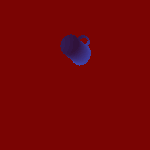

In [4]:
sampler = SceneSampler(
                        # mesh_paths=[Path("sample_objs/bunny.obj")],
                        mesh_paths=[Path("ycb_video_models/models/025_mug/textured_simple.obj")],
                        num_objects=1,
                        max_pose_xy_noise=0.3,
                        )
sampler_no_noise = lambda key: sampler(key, noise=False)
seed = PRNGKey(1234)
tr = trace(sampler_no_noise).get_trace(key=seed)
img, flattened_patches, obs = sampler_no_noise(key=seed)
gt_img = sampler.reconsctruct_from_patches(flattened_patches, (150,150), 15)
gt_img = j.viz.get_depth_image(gt_img)
gt_img

In [5]:
k = split(PRNGKey(90996899),200)[134]
inference.rsample(obs, sampler_no_noise, k)

GaussianMixture.rsample is not a reparameterized sample
/home/aldo/miniconda3/envs/tfp-jax/lib/python3.8/site-packages/jax/_src/numpy/array_methods.py:322: FutureWarning: The arr.split() method is deprecated. Use jax.numpy.split instead.
  warnings.warn(
GaussianMixture.rsample is not a reparameterized sample
GaussianMixture.rsample is not a reparameterized sample
GaussianMixture.rsample is not a reparameterized sample
GaussianMixture.rsample is not a reparameterized sample
GaussianMixture.rsample is not a reparameterized sample


({'num_objects': Array(0, dtype=int32),
  'type_of_object_0': Array(0, dtype=int32),
  'pose_0_sqrt_depth': Array(1.5770917, dtype=float32),
  'pose_0_x': Array(-0.7935951, dtype=float32),
  'pose_0_y': Array(-1.2925174, dtype=float32),
  'rot_0_u0': Array(0.15660945, dtype=float32),
  'rot_0_u1': Array(0.37850577, dtype=float32),
  'rot_0_u2': Array(0.21786034, dtype=float32)},
 OrderedDict([('num_objects',
               {'type': 'sample',
                'name': 'num_objects',
                'fn': <numpyro.distributions.discrete.CategoricalProbs at 0x7f5ea819c490>,
                'args': (),
                'kwargs': {'rng_key': Array([1053191566, 4201901961], dtype=uint32),
                 'sample_shape': ()},
                'value': Array(0, dtype=int32),
                'scale': None,
                'is_observed': False,
                'intermediates': [],
                'cond_indep_stack': [],
                'infer': {}}),
              ('type_of_object_0',
             

{'num_objects': True,
 'type_of_object_0': True,
 'pose_0_sqrt_depth': False,
 'pose_0_x': False,
 'pose_0_y': False,
 'rot_0_u0': False,
 'rot_0_u1': False,
 'rot_0_u2': False,
 'obs': False}

In [28]:
from collections import OrderedDict
from jax import vmap

tr_ = tree_map(lambda x: np.array(x), tr)

vmap(fn)(split(PRNGKey(0), 10))
# inference.rsample_static(obs, tr_, PRNGKey(0))

({'num_objects': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
  'pose_0_sqrt_depth': Array([1.5948024, 1.5589508, 1.5902516, 1.5223716, 1.59116  , 1.5440669,
         1.5090646, 1.5612608, 1.5701963, 1.6029242], dtype=float32),
  'pose_0_x': Array([-1.0522547 , -0.75216126, -0.79253864, -0.8115294 , -1.0991302 ,
         -0.83355856, -0.96975684, -1.0255651 , -1.1594746 , -0.79456234],      dtype=float32),
  'pose_0_y': Array([-1.2197416 , -1.0521553 , -1.1967552 , -1.2704256 , -0.84916663,
         -1.230845  , -1.4960816 , -1.2740896 , -1.039582  , -1.1334774 ],      dtype=float32),
  'rot_0_u0': Array([0.36066422, 0.36330706, 0.85859376, 0.17023663, 0.37211436,
         0.08047368, 0.8132412 , 0.25792724, 0.32402506, 0.67859423],      dtype=float32),
  'rot_0_u1': Array([0.18505004, 0.8192377 , 0.76208526, 0.6364102 , 0.92524624,
         0.8599012 , 0.9032754 , 0.9898066 , 0.8137935 , 0.8931103 ],      dtype=float32),
  'rot_0_u2': Array([0.87195396, 0.09574854, 0.3788818 , 

In [31]:
tree_map(lambda x: x[10], all_samples)

{'num_objects': Array(0, dtype=int32),
 'pose_0_sqrt_depth': Array(1.5510027, dtype=float32),
 'pose_0_x': Array(-0.84949684, dtype=float32),
 'pose_0_y': Array(-1.0617719, dtype=float32),
 'rot_0_u0': Array(0.02857557, dtype=float32),
 'rot_0_u1': Array(0.17887211, dtype=float32),
 'rot_0_u2': Array(0.34474802, dtype=float32),
 'type_of_object_0': Array(0, dtype=int32)}

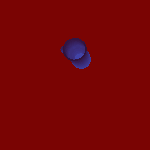

In [36]:
tr_ = OrderedDict({k: v['value'].dtype in (jnp.int32,) for k,v in tr.items()})
fn = lambda k: inference.rsample_static(obs, tr_, k)
all_samples, _, all_log_p = vmap(fn)(split(PRNGKey(2), 1000))

idx = np.concatenate(all_log_p).reshape(-1).argsort()
best = idx[-1]
sampled_variables = tree_map(lambda x: x[best], all_samples)

model_pred = substitute(sampler_no_noise, sampled_variables)
img_, flattened_patches_, obs_ = model_pred(PRNGKey(5343))
pred_img = sampler.reconsctruct_from_patches(flattened_patches_, (150,150), 15)
pred_img = j.viz.get_depth_image(pred_img)
pred_img